# **Прогнозирование стоимости автомобиля по характеристикам**



# 1. Импорт библиотек и подготовка

In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

import re
import sys
import itertools
import datetime
from tqdm.notebook import tqdm
import pandas_profiling
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor
import xgboost as xgb

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 2

In [5]:
# метрика для оценки качества моделей:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 2. Сбор данных и создание объединенного датасета

Спарсить данные с сайта auto.ru не получилось поэтому воспользовался готовыми данными
за октябрь 2021 года, данные по другим месяцам брать не стал так как пошли экономические 
волнения, инфляция ,цены скакали как попало.

In [6]:
# Адреса директорий:
DIR_TRAIN0  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TRAIN1 = '../input/final-car-price-prediction-df-parsed-sep-2021/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [7]:
!ls '../input'

final-car-price-prediction-df-parsed-sep-2021  sf-dst-car-price-prediction
parsing-all-moscow-auto-ru-09-09-2020


In [8]:
# Загрузка данных:
train0 = pd.read_csv(DIR_TRAIN0+'all_auto_ru_09_09_2020.csv') # Октябрь 2021 из Baseline
train1 = pd.read_csv(DIR_TRAIN1+'train_df_full_part1.csv') # Октябрь 2021
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
# Посмотрим что мы имеем в общем виде:
train0.info()
train1.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [10]:
# Объединим все тестовые датасеты в один по принципу 'outer' и посмотрим на итоговый датасет:
combined_check = pd.concat([train0, train1], join='outer', ignore_index=True)
combined_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219579 entries, 0 to 219578
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              219363 non-null  object 
 1   brand                 219366 non-null  object 
 2   color                 219366 non-null  object 
 3   fuelType              219364 non-null  object 
 4   modelDate             219363 non-null  float64
 5   name                  219530 non-null  object 
 6   numberOfDoors         219364 non-null  float64
 7   productionDate        219366 non-null  float64
 8   vehicleConfiguration  219364 non-null  object 
 9   vehicleTransmission   219363 non-null  object 
 10  engineDisplacement    219365 non-null  object 
 11  enginePower           219365 non-null  object 
 12  description           216112 non-null  object 
 13  mileage               192412 non-null  float64
 14  Комплектация          89378 non-null   object 
 15  

In [11]:
# Приведём столбцы к общим названиям взяв за основу названия из тестового датасета:

for train in [train0, train1, test]:
    train.rename(columns={'Владельцы': 'owners', 'Комплектация': 'complectation_dict',
                          'Владение': 'ownership', 'ПТС': 'vehicle_licence','Привод': 'driving_gear', 'Руль': 'steering_wheel',
                          'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)
    


In [12]:
    
for train in [train0, train1, test]:
    train.rename(columns={'model': 'model_name', 'car_url' : 'url'}, inplace=True)


In [13]:
# Снова объединим трейновые датасеты (теперь с подправленными названиями столбцов):
train = pd.concat([train0, train1], join='outer', ignore_index=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219579 entries, 0 to 219578
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              219363 non-null  object 
 1   brand                 219366 non-null  object 
 2   color                 219366 non-null  object 
 3   fuelType              219364 non-null  object 
 4   modelDate             219363 non-null  float64
 5   name                  219530 non-null  object 
 6   numberOfDoors         219364 non-null  float64
 7   productionDate        219366 non-null  float64
 8   vehicleConfiguration  219364 non-null  object 
 9   vehicleTransmission   219363 non-null  object 
 10  engineDisplacement    219365 non-null  object 
 11  enginePower           219365 non-null  object 
 12  description           216112 non-null  object 
 13  mileage               192412 non-null  float64
 14  complectation_dict    194645 non-null  object 
 15  

In [14]:
# Пометим трейновый и тестовый датасеты и добавим столбец price к тестовому датасету заполнив его нолями:
test['price'] = 0.0
train['train'] = 1
test['train'] = 0


In [15]:
# Объединим трейновый и тестовый датасеты в один общий по принципу 'inner' (отбросив лишние столбцы):
comb_df = pd.concat([train, test], join='inner', ignore_index=True)
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254265 entries, 0 to 254264
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              254049 non-null  object 
 1   brand                 254052 non-null  object 
 2   color                 254052 non-null  object 
 3   fuelType              254050 non-null  object 
 4   modelDate             254049 non-null  float64
 5   name                  254216 non-null  object 
 6   numberOfDoors         254050 non-null  float64
 7   productionDate        254052 non-null  float64
 8   vehicleConfiguration  254050 non-null  object 
 9   vehicleTransmission   254049 non-null  object 
 10  engineDisplacement    254051 non-null  object 
 11  enginePower           254051 non-null  object 
 12  description           250798 non-null  object 
 13  mileage               227098 non-null  float64
 14  complectation_dict    201063 non-null  object 
 15  

# 3. Обработка данных и EDA

## 3.1. Первичный EDA (Pandas profiling)

In [16]:
from pandas_profiling import ProfileReport


In [17]:
## Сделаем первичный EDA с помощью Pandas profiling
#profile = ProfileReport(comb_df, title = 'Pandas Profiling Report')
#profile

Много повторяющихся данных в столбцах, пропуски, названия колонок на разных языках и т.д
Надо почистить данные и подготовить к созданию модели.

## 3.2. Очистка данных

Переберем все столбцы по порядку и подчистим значения.

*столбец bodyType*

In [18]:
comb_df.bodyType.value_counts(normalize=True)

внедорожник 5 дв.          0.343619
седан                      0.177234
Внедорожник 5 дв.          0.125507
Седан                      0.120422
Хэтчбек 5 дв.              0.034119
                             ...   
Седан Latio                0.000004
Хэтчбек 5 дв. Runx         0.000004
Минивэн Caravan Elgrand    0.000004
Седан LWB                  0.000004
Седан SRT                  0.000004
Name: bodyType, Length: 192, dtype: float64

In [19]:
comb_df.bodyType = comb_df.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
comb_df.bodyType.value_counts(normalize=True)

внедорожник      0.472523
седан            0.303064
хэтчбек          0.070364
лифтбек          0.047440
минивэн          0.028506
универсал        0.025723
купе             0.019004
компактвэн       0.015981
пикап            0.009601
фургон           0.003137
купе-хардтоп     0.001645
кабриолет        0.001354
родстер          0.001181
микровэн         0.000240
седан-хардтоп    0.000126
лимузин          0.000051
тарга            0.000043
фастбек          0.000016
Name: bodyType, dtype: float64

*столбец brand*

In [20]:
comb_df.brand.value_counts(normalize=True)

MERCEDES      0.116787
VOLKSWAGEN    0.116307
TOYOTA        0.113575
BMW           0.106372
NISSAN        0.105093
AUDI          0.069895
MITSUBISHI    0.067431
SKODA         0.055469
VOLVO         0.027778
HONDA         0.027376
HYUNDAI       0.022570
LEXUS         0.022554
KIA           0.022161
FORD          0.018882
CHEVROLET     0.014300
INFINITI      0.013643
OPEL          0.012257
RENAULT       0.010679
MAZDA         0.009097
PEUGEOT       0.006459
LAND_ROVER    0.006388
CITROEN       0.004511
DAEWOO        0.004098
SUBARU        0.003669
SUZUKI        0.003432
SSANG_YONG    0.002822
PORSCHE       0.002807
CHERY         0.002228
JEEP          0.001901
GREAT_WALL    0.001653
DODGE         0.001645
CHRYSLER      0.001271
CADILLAC      0.001267
JAGUAR        0.001232
MINI          0.001228
GEELY         0.001161
Name: brand, dtype: float64

In [21]:
comb_df.brand = comb_df.brand.apply(lambda x: x.lower() if isinstance(x, str) else x)
comb_df.brand.value_counts(normalize=True)

mercedes      0.116787
volkswagen    0.116307
toyota        0.113575
bmw           0.106372
nissan        0.105093
audi          0.069895
mitsubishi    0.067431
skoda         0.055469
volvo         0.027778
honda         0.027376
hyundai       0.022570
lexus         0.022554
kia           0.022161
ford          0.018882
chevrolet     0.014300
infiniti      0.013643
opel          0.012257
renault       0.010679
mazda         0.009097
peugeot       0.006459
land_rover    0.006388
citroen       0.004511
daewoo        0.004098
subaru        0.003669
suzuki        0.003432
ssang_yong    0.002822
porsche       0.002807
chery         0.002228
jeep          0.001901
great_wall    0.001653
dodge         0.001645
chrysler      0.001271
cadillac      0.001267
jaguar        0.001232
mini          0.001228
geely         0.001161
Name: brand, dtype: float64

*столбец color*

In [22]:
comb_df.color.value_counts()

чёрный         53226
белый          37762
040001         25212
серый          21364
FAFBFB         15824
синий          14147
серебристый    13959
CACECB         11336
97948F         10819
0000CC          8874
красный         7577
коричневый      5619
EE1D19          4508
зелёный         3619
200204          3583
бежевый         3191
007F00          2598
C49648          1854
голубой         1744
22A0F8          1398
DEA522           774
660099           750
FFD600           701
пурпурный        614
4A2197           606
FF8649           516
фиолетовый       489
золотистый       471
оранжевый        465
жёлтый           399
розовый           28
FFC0CB            25
Name: color, dtype: int64

In [23]:
# заменим цифровые наименования цветов более понятными:
color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый', '0000CC': 'синий', '200204': 'коричневый',
              'EE1D19': 'красный',  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

comb_df.color.replace(to_replace=color_dict, inplace=True)
comb_df.color.value_counts(normalize=True)

чёрный         0.308748
белый          0.210925
серый          0.126679
серебристый    0.099566
синий          0.090615
красный        0.047569
коричневый     0.036221
зелёный        0.024471
бежевый        0.019858
голубой        0.012368
пурпурный      0.005369
золотистый     0.004901
жёлтый         0.004330
фиолетовый     0.004310
оранжевый      0.003861
розовый        0.000209
Name: color, dtype: float64

*столбец fuelType*

In [24]:
comb_df.fuelType.value_counts(normalize=True)

бензин       0.803232
дизель       0.188164
гибрид       0.006235
электро      0.002287
газ          0.000079
универсал    0.000004
Name: fuelType, dtype: float64

In [25]:
comb_df.fuelType = comb_df.fuelType.apply(lambda x: x.lower().strip() if isinstance(x, str) else x)
comb_df.fuelType = comb_df.fuelType.apply(lambda x: (x.replace('универсал', "бензин")) if isinstance(x, str) else x)
comb_df.fuelType = comb_df.fuelType.apply(lambda x: (x.replace('гибрид', "бензин")) if isinstance(x, str) else x)
comb_df.fuelType.value_counts(normalize=True)

бензин     0.809471
дизель     0.188164
электро    0.002287
газ        0.000079
Name: fuelType, dtype: float64

*столбец name*

In [26]:
comb_df.name.value_counts()

Nissan X-Trail III Рестайлинг            4013
Volkswagen Tiguan II Рестайлинг          3429
Toyota RAV4 V (XA50)                     2171
Volkswagen Tiguan II                     2068
Mitsubishi Outlander III Рестайлинг 3    2054
                                         ... 
220 2.2d MT (125 л.с.)                      1
2.0 AT (164 л.с.)                           1
Toyota Sequoia                              1
BMW i3 94Ah I (I01) Рестайлинг              1
63 AMG 5.5 AT (564 л.с.)                    1
Name: name, Length: 7057, dtype: int64

In [27]:
comb_df.model_name.value_counts()

Tiguan                 4592
X-Trail                3780
A6                     3597
Land Cruiser           3315
Touareg                3019
                       ... 
ORION                     1
SVX                       1
Delica D:2                1
LANTIS                    1
EXPLORER_SPORT_TRAC       1
Name: model_name, Length: 1506, dtype: int64

In [28]:
comb_df.enginePower.value_counts()

249 N12    15970
150 N12    12118
190 N12     7475
150.0       7058
110 N12     4380
           ...  
680.0          1
700.0          1
702.0          1
761.0          1
11.0           1
Name: enginePower, Length: 734, dtype: int64

Столбец name повторяет столбцы model_name и engine_power. Удалим его предварительно передав данные для заполнения пропусков столбца model_name

In [29]:
comb_df.model_name.fillna(comb_df.name, inplace=True)
comb_df.drop(['name'], axis=1, inplace=True)

*столбец numberOfDoors*

In [30]:
comb_df.numberOfDoors.value_counts()

5.0    161022
4.0     82899
2.0      6023
3.0      4104
0.0         2
Name: numberOfDoors, dtype: int64

*столбец productionDate*

In [31]:
comb_df.productionDate.value_counts()

2021.0    30088
2020.0    19090
2018.0    18459
2013.0    15662
2011.0    15437
          ...  
1931.0        1
1971.0        1
1924.0        1
1923.0        1
1955.0        1
Name: productionDate, Length: 81, dtype: int64

*столбец vehicleConfiguration*

In [32]:
comb_df.vehicleConfiguration.value_counts()

ALLROAD_5_DOORS VARIATOR 2.0            14593
ALLROAD_5_DOORS AUTOMATIC 2.0           13857
ALLROAD_5_DOORS AUTOMATIC 3.0           13836
SEDAN AUTOMATIC 2.0                      8780
SEDAN AUTOMATIC 1.6                      7812
                                        ...  
HATCHBACK_5_DOORS AUTOMATIC Electric        1
HATCHBACK_3_DOORS VARIATOR 200              1
ALLROAD_OPEN MECHANICAL 3.0                 1
WAGON_5_DOORS VARIATOR Plus                 1
CABRIO MECHANICAL 1.5d                      1
Name: vehicleConfiguration, Length: 2068, dtype: int64

Столбец vehicleConfiguration повторяет столбцы vehicleTransmission, engineDisplacement, bodyType, numberOfDoors. Удалим его. И сразу посмотрим столбец vehicleTransmission

In [33]:
comb_df.drop(['vehicleConfiguration'], axis=1, inplace=True)
comb_df.vehicleTransmission.value_counts()

автоматическая      93432
AUTOMATIC           49218
вариатор            28460
MECHANICAL          25264
механическая        22700
роботизированная    20080
ROBOT                7871
VARIATOR             7024
Name: vehicleTransmission, dtype: int64

In [34]:
comb_df.vehicleTransmission.value_counts(normalize=True)

автоматическая      0.367772
AUTOMATIC           0.193734
вариатор            0.112026
MECHANICAL          0.099445
механическая        0.089353
роботизированная    0.079040
ROBOT               0.030982
VARIATOR            0.027648
Name: vehicleTransmission, dtype: float64

In [35]:
# создадим и передадим словарь для переименований:
transmission_dict = {'AUTOMATIC': 'автоматическая', 'MECHANICAL' : 'механическая',
                        'ROBOT' : 'роботизированная', 'VARIATOR' : 'вариатор'}

comb_df.vehicleTransmission.replace(to_replace=transmission_dict, inplace=True)
comb_df.vehicleTransmission.value_counts(normalize=True)

автоматическая      0.561506
механическая        0.188798
вариатор            0.139674
роботизированная    0.110022
Name: vehicleTransmission, dtype: float64

Уже лучше!

*столбец engineDisplacement*

In [36]:
comb_df.engineDisplacement.value_counts(normalize=True)

2.0 LTR    0.174469
3.0 LTR    0.079291
1.6 LTR    0.073155
1.6        0.067042
2.5 LTR    0.053836
             ...   
130i       0.000004
1.4hyb     0.000004
218d       0.000004
3.9d       0.000004
733i       0.000004
Name: engineDisplacement, Length: 589, dtype: float64

In [37]:
def engineDisplacement_to_float(item):
    try:
        return float(item)
    except:
        return 2.0 # наиболее часто встречающийся объем двигателя
    
def cc_to_ltr(item):
    if item > 10:
        return round((item/1000), 1)
    else:
        return item
    
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(lambda x: (x.replace("LTR", "")) if isinstance(x, str) else x)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(lambda x: (x.replace("d", "")) if isinstance(x, str) else x)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(engineDisplacement_to_float)
comb_df.engineDisplacement = comb_df.engineDisplacement.apply(cc_to_ltr)
comb_df.engineDisplacement.value_counts(normalize=True)

2.0    0.273973
1.6    0.140932
3.0    0.089266
2.5    0.070041
1.4    0.061452
         ...   
7.5    0.000004
7.4    0.000004
6.5    0.000004
6.7    0.000004
7.3    0.000004
Name: engineDisplacement, Length: 72, dtype: float64

*столбец enginePower*

In [38]:
comb_df.enginePower.value_counts(normalize=True)

249 N12    0.062861
150 N12    0.047699
190 N12    0.029423
150.0      0.027782
110 N12    0.017241
             ...   
680.0      0.000004
700.0      0.000004
702.0      0.000004
761.0      0.000004
11.0       0.000004
Name: enginePower, Length: 734, dtype: float64

In [39]:
def enginePower_to_float(item):
    try:
        return float(item)
    except:
        return float(150) # наиболее часто встречающаяся мощность

comb_df.enginePower = comb_df.enginePower.apply(lambda x: x.split()[0].strip() if isinstance(x, str) else x)
comb_df.enginePower = comb_df.enginePower.apply(enginePower_to_float)
comb_df.enginePower.value_counts(normalize=True)

249.0    0.077508
150.0    0.075489
190.0    0.037638
110.0    0.025479
105.0    0.022433
           ...   
700.0    0.000004
437.0    0.000004
646.0    0.000004
17.0     0.000004
570.0    0.000004
Name: enginePower, Length: 409, dtype: float64

*столбец description*

In [40]:
comb_df.description.head(5)

0     Машина  в приличном состоянии ,не гнилая не р...
1    Машина в оригинале не гнилая все вопросы по те...
2    ПТС Оригинал!\nПолный комплект ключей!\nПо рез...
3                                                  NaN
4    Машина не гнилая, дыр нет, днище целое, даже в...
Name: description, dtype: object

Это описание машин от владельцев, удалим его.

In [41]:
comb_df.drop(['description'], axis=1, inplace=True)

*столбец complectation_dict*

In [42]:
comb_df.complectation_dict.tail(20)

254245    {"id":"20580761","name":"328i","available_opti...
254246                                                  NaN
254247    {"id":"21037026","name":"520d xDrive","availab...
254248    {"id":"21078977","name":"318i","available_opti...
254249                                                  NaN
254250                                                  NaN
254251                                                  NaN
254252                                                  NaN
254253                                                  NaN
254254                                                  NaN
254255                                                  NaN
254256                                                  NaN
254257                                                  NaN
254258                                                  NaN
254259                                                  NaN
254260                                                  NaN
254261                                  

Столбец complectation_dict повторяет информацию других столбцов. Удалим.

In [43]:
comb_df.drop(['complectation_dict'], axis=1, inplace=True)

*столбец driving_gear*

In [44]:
comb_df.driving_gear.value_counts()

полный      108584
передний    100745
задний       17766
Name: driving_gear, dtype: int64

*столбец steering_wheel*

In [45]:
comb_df.steering_wheel.value_counts()

Левый     132643
LEFT       87589
Правый      5076
RIGHT       1789
Name: steering_wheel, dtype: int64

In [46]:
# создадим словарь для переименований:
steering_wheel_dict = {'LEFT': 'Левый', 'RIGHT' : 'Правый'}

# переименуем и уберем заглавные буквы
comb_df.steering_wheel.replace(to_replace=steering_wheel_dict, inplace=True)
comb_df.steering_wheel = comb_df.steering_wheel.apply(lambda x: x.lower() if isinstance(x, str) else x)
comb_df.steering_wheel.value_counts(normalize=True)

левый     0.969771
правый    0.030229
Name: steering_wheel, dtype: float64

*столбец condition*

In [47]:
comb_df.condition.value_counts()

Не требует ремонта    137718
Name: condition, dtype: int64

В дальнейшем "не требует ремонта" придется поменять на 1 и 0

столбец owners

In [48]:
comb_df.owners.value_counts()

3 или более    49760
1 владелец     40576
3.0            36248
2 владельца    28655
2.0            21006
1.0            18536
1 владелец      9459
2 владельца     9270
Name: owners, dtype: int64

In [49]:
comb_df.owners.unique()

array([3.0, 1.0, 2.0, nan, '3 или более', '1 владелец', '2 владельца',
       '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [50]:
# создадим и передадим словарь для переименований:
owners_dict = {'1 владелец': '1.0', '1\xa0владелец': '1.0','2\xa0владельца': '2.0',
               '2 владельца': '2.0', '3 или более' : '3.0'}

comb_df.owners.replace(to_replace=owners_dict, inplace=True)
comb_df.owners = comb_df.owners.apply(lambda x: float(x) if isinstance(x, str) else x)
comb_df.owners.value_counts(normalize=True)

3.0    0.402829
1.0    0.321161
2.0    0.276010
Name: owners, dtype: float64

*столбец vehicle_licence*

In [51]:
comb_df.vehicle_licence.value_counts()

Оригинал     122685
ORIGINAL      78597
Дубликат      15034
DUPLICATE     10420
Name: vehicle_licence, dtype: int64

In [52]:
# создадим и передадим словарь для переименований:
vehicle_licence_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE' : 'Дубликат'}

comb_df.vehicle_licence.replace(to_replace=vehicle_licence_dict, inplace=True)
comb_df.vehicle_licence = comb_df.vehicle_licence.apply(lambda x: x.lower() if isinstance(x, str) else x)
comb_df.vehicle_licence.value_counts(normalize=True)

оригинал    0.887737
дубликат    0.112263
Name: vehicle_licence, dtype: float64

*столбец customs*

In [53]:
comb_df.customs.value_counts()

Растаможен    137716
True           89378
Name: customs, dtype: int64

In [54]:
comb_df.customs.unique()

array([True, 'Растаможен', nan], dtype=object)

In [55]:
# Столбец бинарен, заменим значения на 0 - нет значений и 1 - растаможен:
comb_df.customs = comb_df.customs.apply(lambda x: 1 if x == 'Растаможен' or x == True else 0)
comb_df.customs.value_counts()

1    227094
0     27171
Name: customs, dtype: int64

*столбец ownership*

In [56]:
comb_df.ownership.value_counts()

3 года и 2 месяца              790
10 месяцев                     757
7 месяцев                      745
3 года и 6 месяцев             601
2 года и 9 месяцев             597
                              ... 
{'year': 1989, 'month': 12}      1
26 лет и 3 месяца                1
19 лет и 4 месяца                1
22 года и 3 месяца               1
{'year': 2000, 'month': 9}       1
Name: ownership, Length: 595, dtype: int64

Cтолбец ownership выдает информацию о времени нахождения у последнего владельца?.Нам она не нужна. Удалим.

In [57]:
comb_df.drop(['ownership'], axis=1, inplace=True)

*столбец model_name*

In [58]:
comb_df.model_name.value_counts()

Tiguan                                                   4592
X-Trail                                                  3780
A6                                                       3597
Land Cruiser                                             3315
Touareg                                                  3019
                                                         ... 
IST                                                         1
BMW 7 серии Long 740Li xDrive VI (G11/G12) Рестайлинг       1
N_ONE                                                       1
Sprinter Carib                                              1
AVANTIME                                                    1
Name: model_name, Length: 1771, dtype: int64

In [59]:
comb_df.model_name = comb_df.model_name.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
comb_df.model_name.value_counts()

tiguan           6119
octavia          5198
polo             4932
camry            4478
mercedes-benz    4311
                 ... 
ds                  1
dart                1
orion               1
golf_r32            1
lancer_cargo        1
Name: model_name, Length: 1212, dtype: int64

*столбец url*

In [60]:
comb_df.url.tail(1000)

253265    https://auto.ru/cars/used/sale/bmw/x6/11013618...
253266    https://auto.ru/cars/used/sale/bmw/x3/11013611...
253267    https://auto.ru/cars/used/sale/bmw/5er/1101368...
253268    https://auto.ru/cars/used/sale/bmw/x5/11013684...
253269    https://auto.ru/cars/used/sale/bmw/7er/1101368...
                                ...                        
254260    https://auto.ru/cars/used/sale/bmw/3er/1101369...
254261    https://auto.ru/cars/used/sale/bmw/5er/1101369...
254262    https://auto.ru/cars/used/sale/bmw/5er/1101364...
254263    https://auto.ru/cars/used/sale/bmw/x1/11013625...
254264    https://auto.ru/cars/used/sale/bmw/x5/11012560...
Name: url, Length: 1000, dtype: object

столбец url бесполезен для нас. Удалим.

In [61]:
comb_df.drop(['url'], axis=1, inplace=True)

*Столбец image*

In [62]:
comb_df.image.tail(1000)

253265    https://avatars.mds.yandex.net/get-autoru-vos/...
253266    https://avatars.mds.yandex.net/get-autoru-vos/...
253267    https://autoru.naydex.net/FwiuJ8975/366aceFl8F...
253268    https://avatars.mds.yandex.net/get-autoru-vos/...
253269    https://autoru.naydex.net/FwiuJ8975/366aceFl8F...
                                ...                        
254260    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
254261    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
254262    https://avatars.mds.yandex.net/get-autoru-vos/...
254263    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
254264    https://avatars.mds.yandex.net/get-autoru-vos/...
Name: image, Length: 1000, dtype: object

столбец image не несёт важной для нас информации. Удалим.

In [63]:
comb_df.drop(['image'], axis=1, inplace=True)

*столбец model_info*

In [64]:
comb_df.model_info.tail(100)

254165    {"code":"VITZ","name":"Vitz","ru_name":"Витц",...
254166    {"code":"ALPHARD","name":"Alphard","ru_name":"...
254167    {"code":"MARK_II","name":"Mark II","ru_name":"...
254168    {"code":"CAMRY","name":"Camry","ru_name":"Камр...
254169    {"code":"ALPHARD","name":"Alphard","ru_name":"...
                                ...                        
254260    {"code":"3ER","name":"3 серии","ru_name":"3 се...
254261    {"code":"5ER","name":"5 серии","ru_name":"5 се...
254262    {"code":"5ER","name":"5 серии","ru_name":"5 се...
254263    {"code":"X1","name":"X1","ru_name":"Х1","morph...
254264    {"code":"X5","name":"X5","ru_name":"Х5","morph...
Name: model_info, Length: 100, dtype: object

In [65]:
# полезной для нас информации здесь нет, удаляем
comb_df.drop(['model_info'], axis=1, inplace=True)

*столбец parsing_unixtime*

In [66]:
comb_df.parsing_unixtime.tail(100)

254165    1.603691e+09
254166    1.603691e+09
254167    1.603691e+09
254168    1.603691e+09
254169    1.603691e+09
              ...     
254260    1.603708e+09
254261    1.603708e+09
254262    1.603708e+09
254263    1.603708e+09
254264    1.603710e+09
Name: parsing_unixtime, Length: 100, dtype: float64

In [67]:
# Эта информация для нас бесполезна, удаляем
comb_df.drop(['parsing_unixtime'], axis=1, inplace=True)

*столбец priceCurrency*

In [68]:
comb_df.priceCurrency.value_counts()

RUB    164655
RUR       184
Name: priceCurrency, dtype: int64

In [69]:
# Нам не нужен, удалим
comb_df.drop(['priceCurrency'], axis=1, inplace=True)

*столбец sell_id*

In [70]:
comb_df.sell_id.tail(100)

254165    1.101366e+09
254166    1.101365e+09
254167    1.101365e+09
254168    1.101365e+09
254169    1.101363e+09
              ...     
254260    1.101369e+09
254261    1.101370e+09
254262    1.101365e+09
254263    1.101363e+09
254264    1.101256e+09
Name: sell_id, Length: 100, dtype: float64

*столбец super_gen*

In [71]:
comb_df.super_gen.tail(100)

254165    {"id":"20399205","displacement":996,"engine_ty...
254166    {"id":"7747288","displacement":3456,"engine_ty...
254167    {"id":"8304742","displacement":1988,"engine_ty...
254168    {"id":"20230017","displacement":1998,"engine_t...
254169    {"id":"7747288","displacement":3456,"engine_ty...
                                ...                        
254260    {"id":"8546464","name":"316","nameplate":"316i...
254261    {"id":"20856402","name":"520","nameplate":"520...
254262    {"id":"6329747","name":"523","nameplate":"523i...
254263    {"id":"8247004","name":"20d","nameplate":"20d"...
254264    {"id":"20390090","name":"30d","nameplate":"30d...
Name: super_gen, Length: 100, dtype: object

In [72]:
# повторяется информация из других столбцов, удалим его
comb_df.drop(['super_gen'], axis=1, inplace=True)

*столбец vendor*

In [73]:
comb_df.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [74]:
comb_df.vendor.tail(100)

254165    JAPANESE
254166    JAPANESE
254167    JAPANESE
254168    JAPANESE
254169    JAPANESE
            ...   
254260    EUROPEAN
254261    EUROPEAN
254262    EUROPEAN
254263    EUROPEAN
254264    EUROPEAN
Name: vendor, Length: 100, dtype: object

In [75]:
# бесполезный столбец, удаляем
comb_df.drop(['vendor'], axis=1, inplace=True)

In [76]:
# посмотрим что получилось
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254265 entries, 0 to 254264
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             254049 non-null  object 
 1   brand                254052 non-null  object 
 2   color                254052 non-null  object 
 3   fuelType             254050 non-null  object 
 4   modelDate            254049 non-null  float64
 5   numberOfDoors        254050 non-null  float64
 6   productionDate       254052 non-null  float64
 7   vehicleTransmission  254049 non-null  object 
 8   engineDisplacement   254051 non-null  float64
 9   enginePower          254051 non-null  float64
 10  mileage              227098 non-null  float64
 11  driving_gear         227095 non-null  object 
 12  steering_wheel       227097 non-null  object 
 13  condition            137718 non-null  object 
 14  owners               213510 non-null  float64
 15  vehicle_licence  

## 3.3. Удаление дубликатов и заполнение пропусков

In [77]:
# Посмотрим на количество дубликатов и удалим их:
print(sum(comb_df.duplicated()))
print(comb_df.shape)
comb_df.drop_duplicates(inplace=True)
comb_df.shape

95433
(254265, 22)


(158832, 22)

In [78]:
# Посмотрим на пропуски в train и test порциях датасета по отдельности.
print(comb_df[comb_df.train == 0].isna().sum(axis=0) * 100 / comb_df[comb_df.train == 0].shape[0])
print()
print(comb_df[comb_df.train == 1].isna().sum(axis=0) * 100 / comb_df[comb_df.train == 1].shape[0])

bodyType                0.000000
brand                   0.000000
color                   0.000000
fuelType                0.000000
modelDate               0.000000
numberOfDoors           0.000000
productionDate          0.000000
vehicleTransmission     0.000000
engineDisplacement      0.000000
enginePower             0.000000
mileage                 0.000000
driving_gear            0.000000
steering_wheel          0.000000
condition               0.000000
owners                  0.000000
vehicle_licence         0.002883
customs                 0.000000
price                   0.000000
model_name              0.000000
equipment_dict         28.818544
sell_id                 0.000000
train                   0.000000
dtype: float64

bodyType                0.012083
brand                   0.009666
color                   0.009666
fuelType                0.011277
modelDate               0.012083
numberOfDoors           0.011277
productionDate          0.009666
vehicleTransmission     0.0

Столбец equipment_dict содержит много пропусков (как train так и test порции) и из него тяжело вытянуть полезную информацию. Удалим его. Так же заметим что test порция содержит лишь небольшое количество пропусков vehicle_licence и остальные данные полные.

In [79]:
comb_df.drop(['equipment_dict'], axis=1, inplace=True)

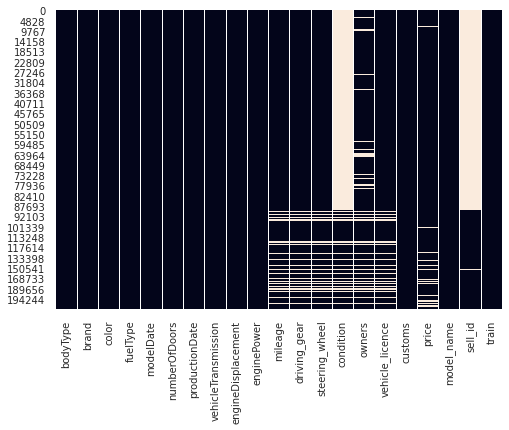

In [80]:
# Посмотрим теперь где поконкретнее пропуски в train порции.
sns.heatmap(comb_df[comb_df.train == 1].isna(), cbar=False);

В датасете из baseline отсутствуют столбцы condition и sell_id. Ничего страшного, эти столбцы не являются основополагающими.

Теперь пройдемся по очереди по всем столбцам с пропусками в объединеном датасете comb_df и заполним пропуски

In [81]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158832 entries, 0 to 254264
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             158817 non-null  object 
 1   brand                158820 non-null  object 
 2   color                158820 non-null  object 
 3   fuelType             158818 non-null  object 
 4   modelDate            158817 non-null  float64
 5   numberOfDoors        158818 non-null  float64
 6   productionDate       158820 non-null  float64
 7   vehicleTransmission  158817 non-null  object 
 8   engineDisplacement   158819 non-null  float64
 9   enginePower          158819 non-null  float64
 10  mileage              151120 non-null  float64
 11  driving_gear         151117 non-null  object 
 12  steering_wheel       151119 non-null  object 
 13  condition            68199 non-null   object 
 14  owners               143430 non-null  float64
 15  vehicle_licence  

Сперва заметим что важный столбец price (наш таргет) имеет пропуски которые мы не в праве заполнить. Поэтому остается только удалить эти строки. Важно что test порция не имеет пропусков (мы заполнили соответствующие ячеки нулевыми значениями)

In [82]:
comb_df.dropna(subset=['price'], inplace=True)

In [83]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154166 entries, 0 to 254264
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             154164 non-null  object 
 1   brand                154166 non-null  object 
 2   color                154166 non-null  object 
 3   fuelType             154165 non-null  object 
 4   modelDate            154164 non-null  float64
 5   numberOfDoors        154164 non-null  float64
 6   productionDate       154166 non-null  float64
 7   vehicleTransmission  154164 non-null  object 
 8   engineDisplacement   154165 non-null  float64
 9   enginePower          154165 non-null  float64
 10  mileage              147447 non-null  float64
 11  driving_gear         147445 non-null  object 
 12  steering_wheel       147446 non-null  object 
 13  condition            64937 non-null   object 
 14  owners               139776 non-null  float64
 15  vehicle_licence  

In [84]:
#небольшое количество пропусков в столбце bodyType заполним наиболее популярным значением:
comb_df['bodyType'].fillna('внедорожник', inplace=True)

In [85]:
# Посмотрим на небольшое количество пропусков в столбце fuelType
comb_df[comb_df.fuelType.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
111208,внедорожник,honda,пурпурный,NaN,NaN,NaN,1989.0,NaN,0.0,150.0,...,NaN,левый,Не требует ремонта,3.0,оригинал,1,110000.0,civic,1.096778e+09,1


In [86]:
# заполним пропуск 
comb_df['fuelType'].fillna('бензин', inplace=True)

Небольшие пропуски в modelDate заменим значениями из столбца productionDate

In [87]:
comb_df['modelDate'].fillna(comb_df['productionDate'], inplace=True)

Количество дверей не является выжным параметром, заполним пропуски наиболее распространенным вариантом: 5 дверей

In [88]:
comb_df['numberOfDoors'].fillna(5, inplace=True)

In [89]:
# Посмотрим на небольшое количество пропусков в столбце vehicleTransmission
comb_df[comb_df.vehicleTransmission.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,NaN,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1
111208,внедорожник,honda,пурпурный,бензин,1989.0,5.0,1989.0,NaN,0.0,150.0,...,NaN,левый,Не требует ремонта,3.0,оригинал,1,110000.0,civic,1.096778e+09,1


Это старые автомобили поэтому заполним пропуски как 'механическая'

In [90]:
comb_df.vehicleTransmission.fillna('механическая', inplace = True)

In [91]:
# Посмотрим на небольшое количество пропусков в столбце engineDisplacement
comb_df[comb_df.engineDisplacement.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,NaN,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1


Это малолитражка Honda Civic, заполним объем двигателя как 1.6

In [92]:
comb_df.engineDisplacement.fillna(1.6, inplace=True)

In [93]:
# Посмотрим на небольшое количество пропусков в столбце enginePower
comb_df[comb_df.enginePower.isna()]

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,1.6,NaN,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1


Опять эта машина! Заполним как 100л.с

In [94]:
comb_df.enginePower.fillna(100, inplace=True)

In [95]:
# Посмотрим что за пропуски в столбце milage (пробег) и какого года выпуска эти автомобили
display(comb_df[comb_df.mileage.isna()])
comb_df[comb_df.mileage.isna()].productionDate.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
89380,лифтбек,skoda,белый,бензин,2020.0,5.0,2021.0,механическая,1.6,90.0,...,NaN,NaN,NaN,NaN,NaN,0,1464100.0,skoda,1.104778e+09,1
89382,внедорожник,skoda,серый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2653190.0,skoda,1.105298e+09,1
89387,внедорожник,skoda,белый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2788433.0,skoda,1.105388e+09,1
89389,внедорожник,skoda,синий,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2808125.0,skoda,1.105064e+09,1
89394,внедорожник,skoda,бежевый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2638230.0,skoda,1.105388e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216085,внедорожник,mitsubishi,белый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,1934675.0,mitsubishi,1.104685e+09,1
216663,внедорожник,mitsubishi,чёрный,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,2510000.0,mitsubishi,1.103457e+09,1
216899,внедорожник,mitsubishi,синий,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,2052000.0,mitsubishi,1.103297e+09,1
217681,внедорожник,mitsubishi,серебристый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,1928500.0,mitsubishi,1.103297e+09,1


2021.0    6638
2020.0      70
2019.0      11
Name: productionDate, dtype: int64

По всей видимости это новые aвтомобили. Пустые значения столбца mileage (пробег) заполним 0

In [96]:
comb_df.mileage.fillna(0, inplace=True)

In [97]:
# Посмотрим что за пропуски в столбце driving_gear и какого типа эти автомобили
display(comb_df[comb_df.driving_gear.isna()])
comb_df[comb_df.driving_gear.isna()].bodyType.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
24624,внедорожник,honda,серебристый,бензин,1989.0,5.0,1989.0,механическая,1.6,100.0,...,NaN,левый,NaN,3.0,оригинал,1,120000.0,civic,NaN,1
89380,лифтбек,skoda,белый,бензин,2020.0,5.0,2021.0,механическая,1.6,90.0,...,NaN,NaN,NaN,NaN,NaN,0,1464100.0,skoda,1.104778e+09,1
89382,внедорожник,skoda,серый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2653190.0,skoda,1.105298e+09,1
89387,внедорожник,skoda,белый,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2788433.0,skoda,1.105388e+09,1
89389,внедорожник,skoda,синий,бензин,2017.0,5.0,2021.0,автоматическая,1.4,150.0,...,NaN,NaN,NaN,NaN,NaN,0,2808125.0,skoda,1.105064e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216085,внедорожник,mitsubishi,белый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,1934675.0,mitsubishi,1.104685e+09,1
216663,внедорожник,mitsubishi,чёрный,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,2510000.0,mitsubishi,1.103457e+09,1
216899,внедорожник,mitsubishi,синий,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,2052000.0,mitsubishi,1.103297e+09,1
217681,внедорожник,mitsubishi,серебристый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,NaN,NaN,NaN,NaN,NaN,0,1928500.0,mitsubishi,1.103297e+09,1


внедорожник    4857
седан          1011
лифтбек         750
минивэн          49
купе             22
хэтчбек          13
универсал        12
пикап             5
фургон            1
родстер           1
Name: bodyType, dtype: int64

Видим что полно внедорожников поэтому заполним пропуски как 'полный' привод

In [98]:
comb_df.driving_gear.fillna('полный', inplace=True)

Пропуски в steering_wheel заполним как 'левый'

In [99]:
comb_df.steering_wheel.fillna('левый', inplace=True)

Столбец condition бинарен, заполним значениями 1 если указано что ремонта не требуетсяб иначе 0

In [100]:
comb_df.condition = comb_df.condition.apply(lambda x: 1 if x == 'Не требует ремонта' else 0)

In [101]:
# Посмотрим что за пропуски в столбце owner и какого года выпуска эти автомобили
display(comb_df[comb_df.owners.isna()])
comb_df[comb_df.owners.isna()].productionDate.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
332,седан,audi,серый,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1885400.0,a3,NaN,1
333,седан,audi,серебристый,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1885400.0,a3,NaN,1
336,седан,audi,синий,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1885400.0,a3,NaN,1
339,седан,audi,синий,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,2016000.0,a3,NaN,1
342,седан,audi,серый,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,NaN,оригинал,1,1946000.0,a3,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216085,внедорожник,mitsubishi,белый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,NaN,NaN,0,1934675.0,mitsubishi,1.104685e+09,1
216663,внедорожник,mitsubishi,чёрный,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,NaN,NaN,0,2510000.0,mitsubishi,1.103457e+09,1
216899,внедорожник,mitsubishi,синий,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,NaN,NaN,0,2052000.0,mitsubishi,1.103297e+09,1
217681,внедорожник,mitsubishi,серебристый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,NaN,NaN,0,1928500.0,mitsubishi,1.103297e+09,1


2020.0    7018
2021.0    6638
2019.0     685
2018.0      48
2017.0       1
Name: productionDate, dtype: int64

В основном новые авто , заменим пропуски 0

In [102]:
comb_df.owners.fillna(0, inplace=True)

In [103]:
# Посмотрим что за пропуски в столбце vehicle_licence и сколько хозяев было у автомобилей
display(comb_df[comb_df.vehicle_licence.isna()])
comb_df[comb_df.vehicle_licence.isna()].owners.value_counts()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,...,driving_gear,steering_wheel,condition,owners,vehicle_licence,customs,price,model_name,sell_id,train
639,седан,audi,синий,бензин,2016.0,4.0,2020.0,роботизированная,1.4,150.0,...,передний,левый,0,0.0,NaN,1,2050000.0,a3,NaN,1
1575,седан,audi,серебристый,бензин,2018.0,4.0,2020.0,роботизированная,0.0,190.0,...,передний,левый,0,0.0,NaN,1,3089848.0,a6,NaN,1
1579,седан,audi,чёрный,бензин,2018.0,4.0,2020.0,роботизированная,0.0,190.0,...,передний,левый,0,0.0,NaN,1,3089848.0,a6,NaN,1
1590,седан,audi,белый,бензин,2018.0,4.0,2020.0,роботизированная,0.0,190.0,...,передний,левый,0,0.0,NaN,1,3089848.0,a6,NaN,1
2273,седан,audi,чёрный,бензин,2018.0,4.0,2020.0,роботизированная,0.0,245.0,...,полный,левый,0,0.0,NaN,1,4435000.0,a6,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216663,внедорожник,mitsubishi,чёрный,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,0.0,NaN,0,2510000.0,mitsubishi,1.103457e+09,1
216899,внедорожник,mitsubishi,синий,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,0.0,NaN,0,2052000.0,mitsubishi,1.103297e+09,1
217681,внедорожник,mitsubishi,серебристый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,0.0,NaN,0,1928500.0,mitsubishi,1.103297e+09,1
219034,внедорожник,mitsubishi,белый,бензин,2018.0,5.0,2021.0,вариатор,2.0,146.0,...,полный,левый,0,0.0,NaN,0,2219675.0,mitsubishi,1.102704e+09,1


0.0    7056
3.0       1
Name: owners, dtype: int64

Это же в подавляющем большинстве те новые автомобили для которых мы заполниои 0 хозяев. Поэтому заполним пропуски как 'оригинал'

In [104]:
comb_df.vehicle_licence.fillna('оригинал', inplace=True)

In [105]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154166 entries, 0 to 254264
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             154166 non-null  object 
 1   brand                154166 non-null  object 
 2   color                154166 non-null  object 
 3   fuelType             154166 non-null  object 
 4   modelDate            154166 non-null  float64
 5   numberOfDoors        154166 non-null  float64
 6   productionDate       154166 non-null  float64
 7   vehicleTransmission  154166 non-null  object 
 8   engineDisplacement   154166 non-null  float64
 9   enginePower          154166 non-null  float64
 10  mileage              154166 non-null  float64
 11  driving_gear         154166 non-null  object 
 12  steering_wheel       154166 non-null  object 
 13  condition            154166 non-null  int64  
 14  owners               154166 non-null  float64
 15  vehicle_licence  

Столбец sell_id в модель подавать не будем но и удалять его не будем потому что он нужен для сабмита. 

## 3.4. EDA

In [106]:
# Посмотрим количество уникальных значений в каждом столбце
comb_df.nunique(dropna=False)

bodyType                  18
brand                     36
color                     16
fuelType                   4
modelDate                 80
numberOfDoors              5
productionDate            81
vehicleTransmission        4
engineDisplacement        72
enginePower              409
mileage                35352
driving_gear               3
steering_wheel             2
condition                  2
owners                     4
vehicle_licence            2
customs                    2
price                  13376
model_name              1206
sell_id                71137
train                      2
dtype: int64

In [107]:
# Сгруппируем признаки по типам
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate']
bin_cols = ['condition', 'customs', 'steering_wheel', 'vehicle_licence']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'model_name', 'driving_gear', 'owners', 'numberOfDoors']
target_cols = ['price']

### 3.4.1. Анализ числовых признаков

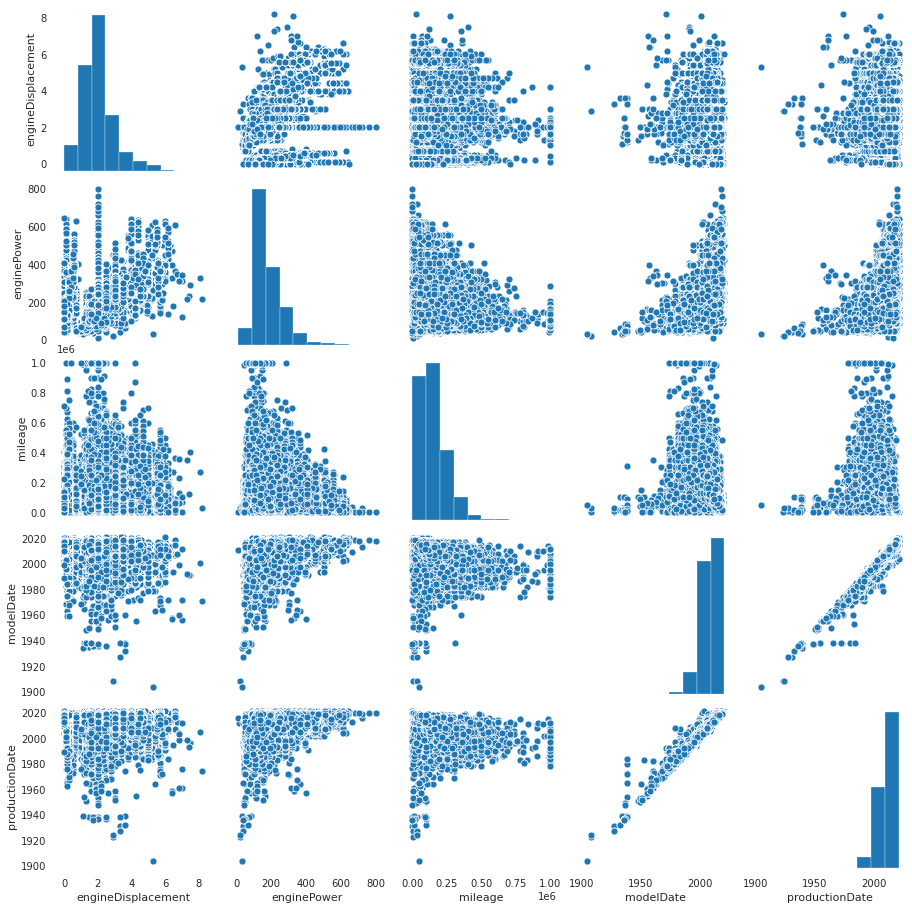

In [108]:
# посмотрим на корреляцию числовых признаков
sns.pairplot(comb_df[num_cols])

Видим сильную корреляцию между modelDate и productionDate что ожидаемо. Есть несколько других закомерностей, например, engine power и productionDate. Есть выбросы.

In [109]:
# Посмотрим на общую информацию
comb_df[num_cols].describe()

,engineDisplacement,enginePower,mileage,modelDate,productionDate
count,154166.000000,154166.000000,154166.000000,154166.000000,154166.000000
mean,2.082644,179.898278,141575.439384,2008.523825,2010.751644
std,0.951910,86.646101,101634.445757,7.428930,7.090821
min,0.000000,11.000000,0.000000,1904.000000,1904.000000
25%,1.600000,120.000000,69000.000000,2005.000000,2007.000000
50%,2.000000,150.000000,133845.000000,2009.000000,2012.000000
75%,2.400000,220.000000,199000.000000,2014.000000,2016.000000
max,8.200000,800.000000,1000000.000000,2021.000000,2021.000000


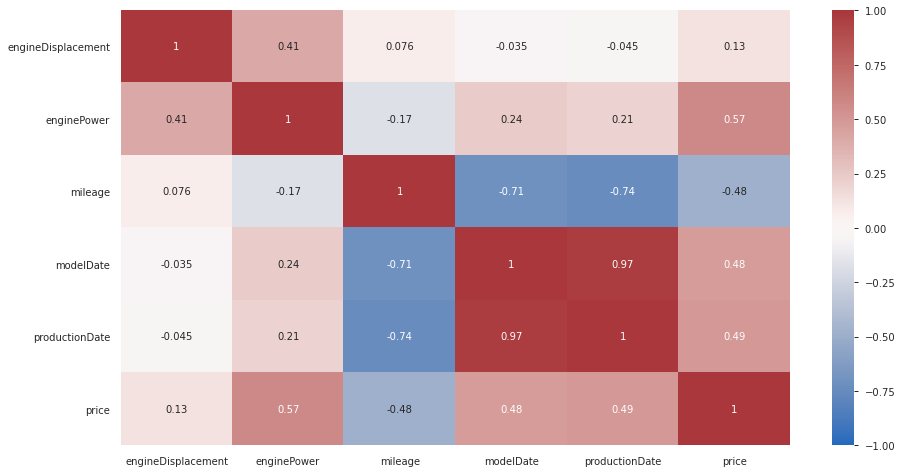

In [110]:
# Посмотрим на корреляцию числовых признаков с ценой (нашим таргетом)
plt.figure(figsize=(15, 8));
sns.heatmap(comb_df[comb_df.train == 1][num_cols + ['price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

Видим что все признаки сильно влияют на цену за исключением engineDisplacement который в свою очередь тесно связан с enginePower. Также modelDate и productionDate показывают сильную взаимосвязь. Удалим engineDisplacement и modelDate

In [111]:
comb_df.drop(['modelDate', 'engineDisplacement'], axis=1, inplace=True)
for col in ['modelDate', 'engineDisplacement']:
    num_cols.remove(col)

### 3.4.2. Анализ бинарных и категоральных признаков

Посмотрим есть ли дисбаланс между трейновой и тестовой выборками

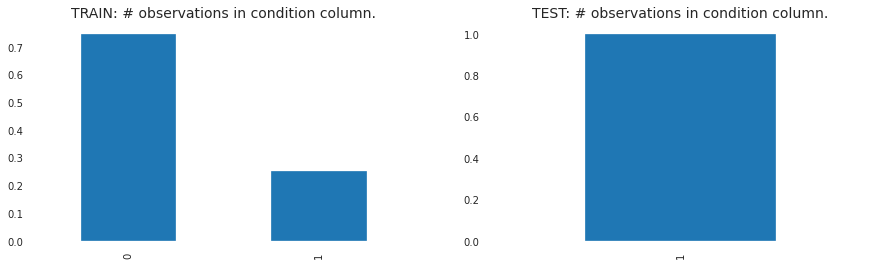

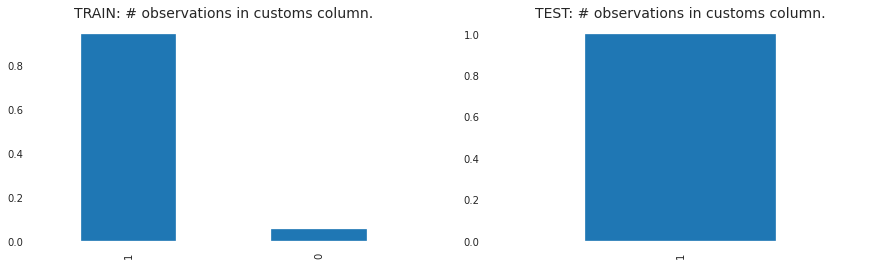

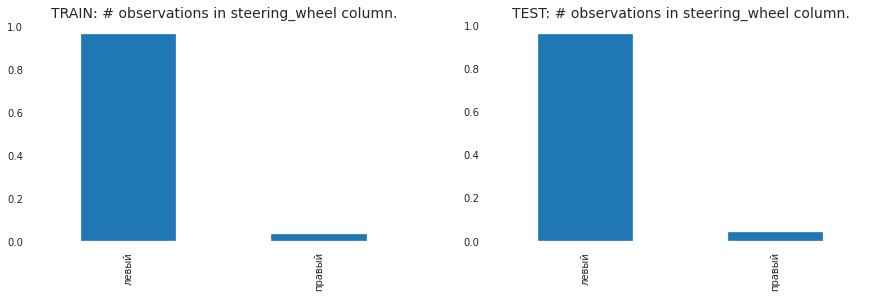

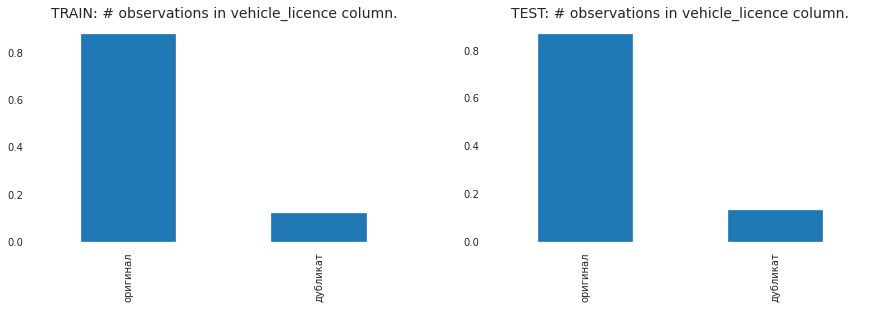

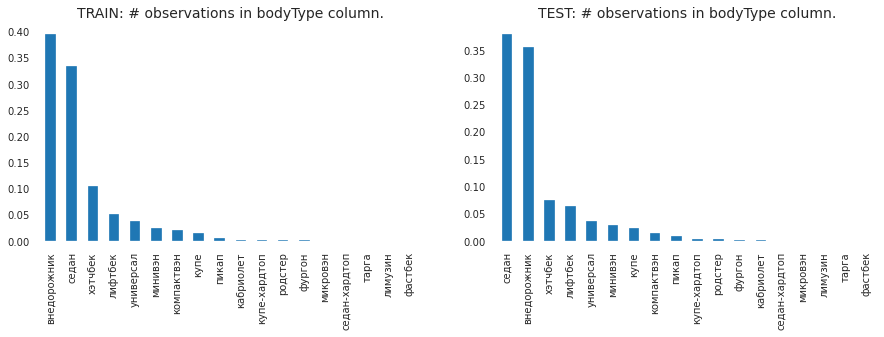

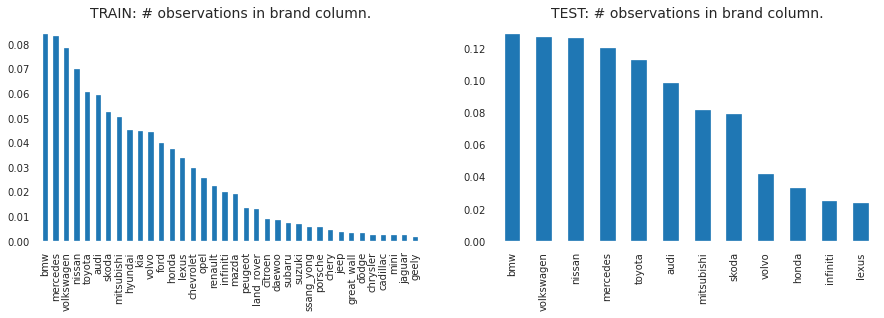

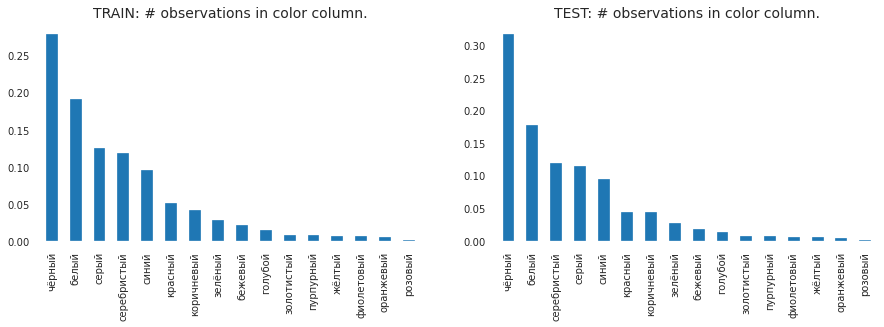

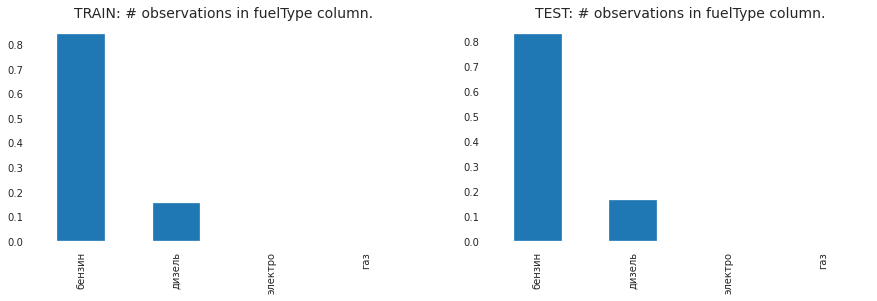

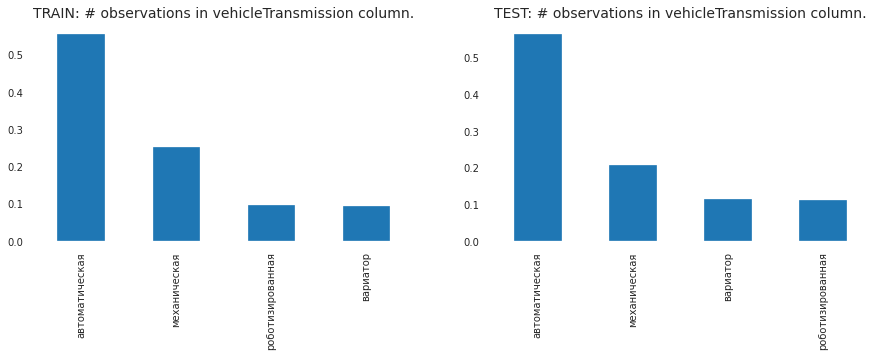

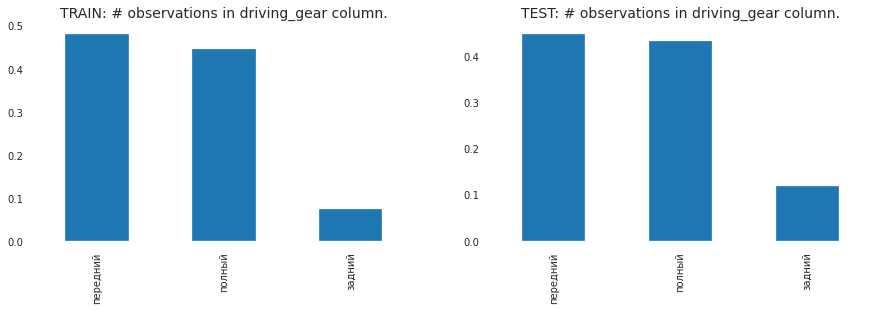

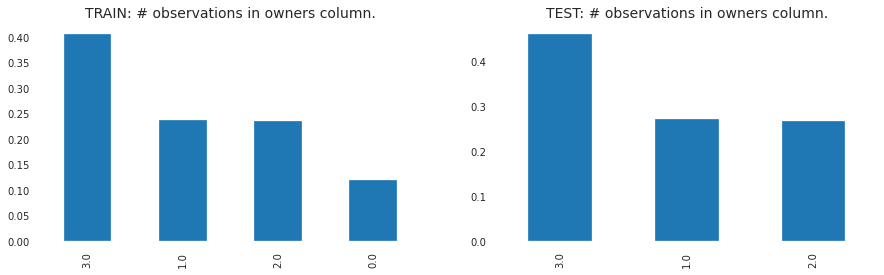

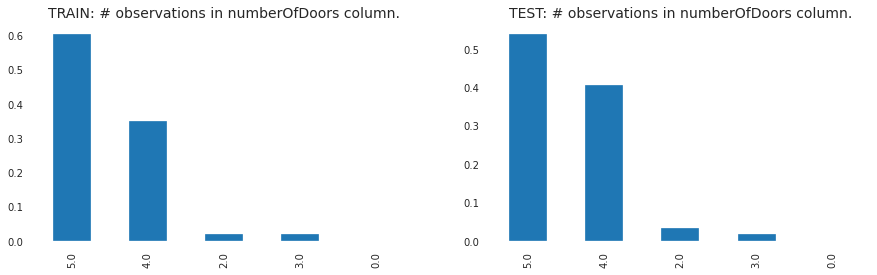

In [112]:
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

Видно что есть существенные перекосы. Тестовая выборка ограничена. Трейновая выборка гораздо шире. Если конкретнее, то столбцы condition и custom не являются бинарными в тестовой выборке (все строки имеют значения "не требует ремонта" и "растаможен"). Также тестовая выборка содержит лишь 12 марок (brands) и меньше категоральных значений в столбцах fuelType и owners. 
*Удалим лишнее и приведём трейновую часть в соответствие с тестовой. Тут надо чётко понимать что мы это делаем для того чтобы не перегружать моделирование и для улучшения точности предсказания для нашей конкретной тестовой части. В обшем случае мы бы этого не делали.**

In [113]:
comb_df = comb_df[comb_df.brand.isin(comb_df[comb_df.train == 0].brand.unique())]

In [114]:
comb_df = comb_df[comb_df.fuelType.isin(comb_df[comb_df.train == 0].fuelType.unique())]

In [115]:
comb_df = comb_df[comb_df.owners.isin(comb_df[comb_df.train == 0].owners.unique())]

In [116]:
comb_df.drop(['condition', 'customs'], axis=1, inplace=True)
for col in ['condition', 'customs']:
    bin_cols.remove(col)
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102771 entries, 0 to 254264
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             102771 non-null  object 
 1   brand                102771 non-null  object 
 2   color                102771 non-null  object 
 3   fuelType             102771 non-null  object 
 4   numberOfDoors        102771 non-null  float64
 5   productionDate       102771 non-null  float64
 6   vehicleTransmission  102771 non-null  object 
 7   enginePower          102771 non-null  float64
 8   mileage              102771 non-null  float64
 9   driving_gear         102771 non-null  object 
 10  steering_wheel       102771 non-null  object 
 11  owners               102771 non-null  float64
 12  vehicle_licence      102771 non-null  object 
 13  price                102771 non-null  float64
 14  model_name           102771 non-null  object 
 15  sell_id          

Треть записей ушло, за то подстроились под тестовый датасет

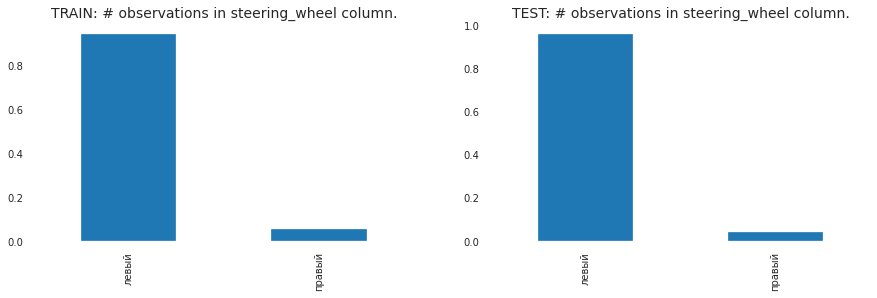

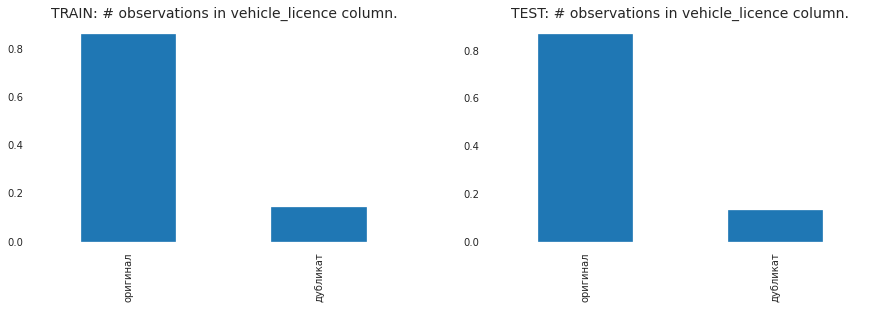

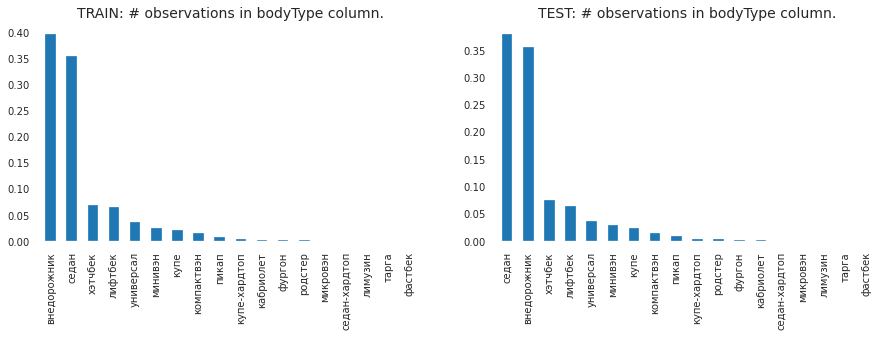

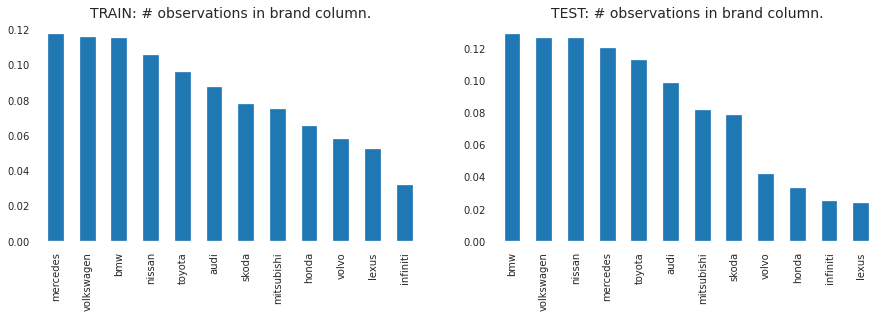

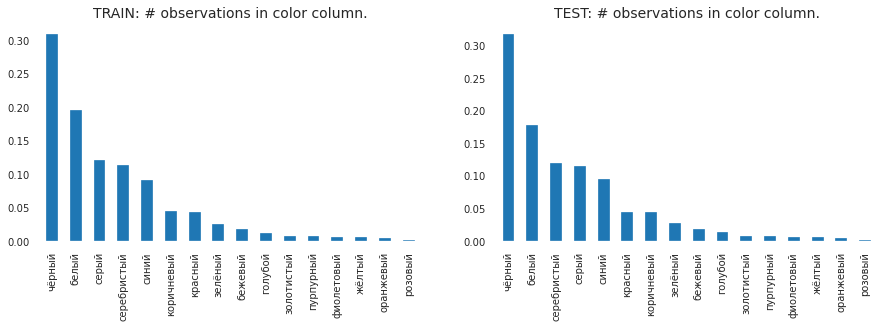

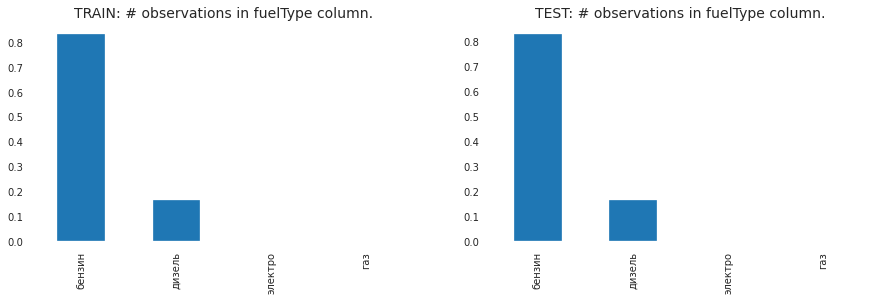

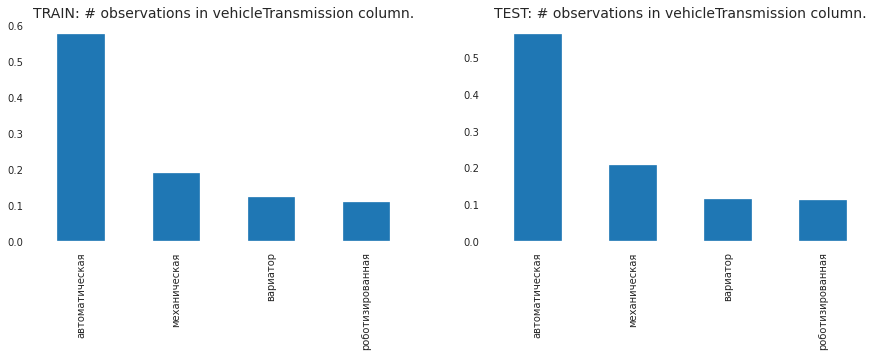

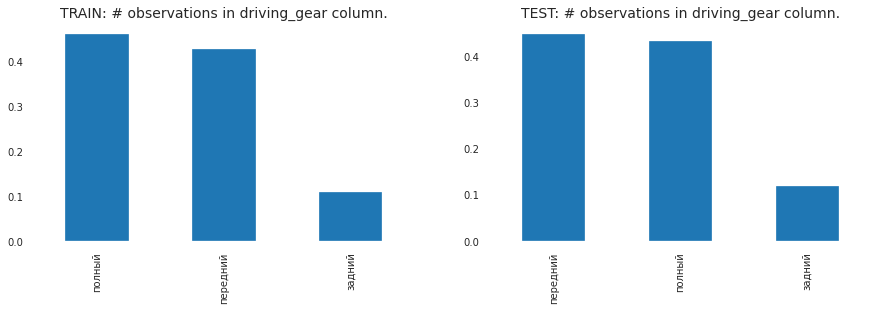

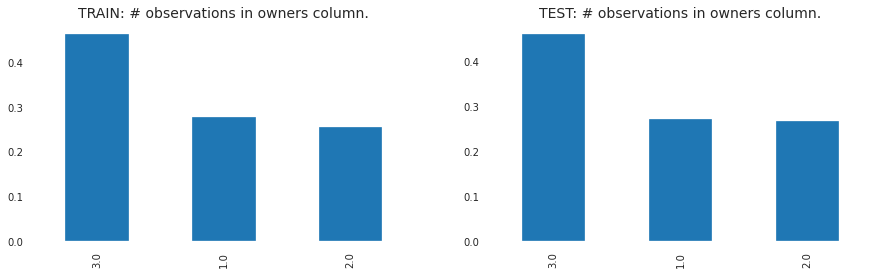

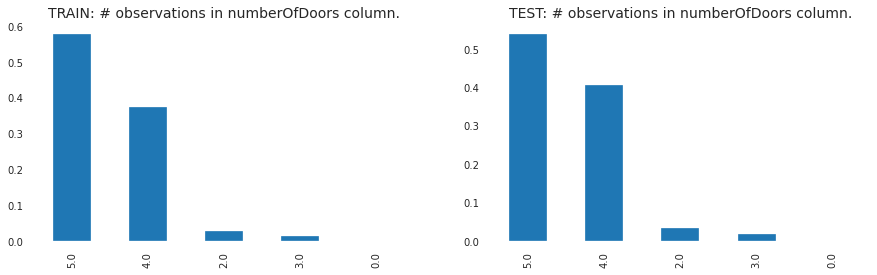

In [117]:
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

Ну что же, что то получилось

### 3.4.3. Анализ таргета (price)

Text(0.5, 0, 'price, RUB * 10^7')

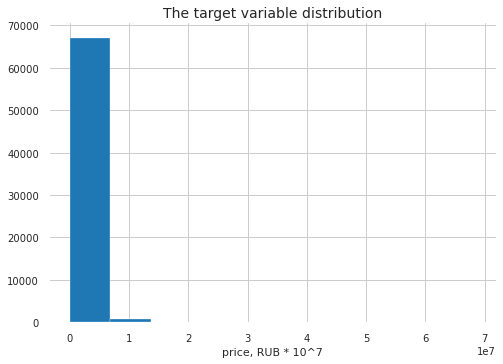

In [118]:
# посмотрим на таргет (price)
comb_df.query('train == 1').price.hist();
plt.title('The target variable distribution', fontdict={'fontsize': 14});
plt.xlabel('price, RUB * 10^7')

Большой хвост по цене, поэтому прологорифмируем наш таргет и добавим его как новый столбец

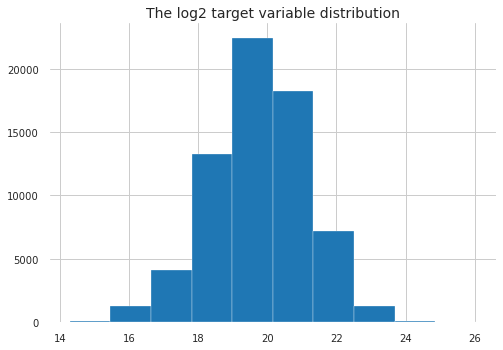

In [119]:
np.log2(comb_df.query('train == 1').price).hist();
plt.title('The log2 target variable distribution', fontdict={'fontsize': 14});
comb_df['price_log2'] = np.log2(comb_df.price + 1)

### 3.4.4. Выбросы

Среднее значение enginePower = 189.721
Среднее значение mileage = 158622.605
Среднее значение productionDate = 2009.757


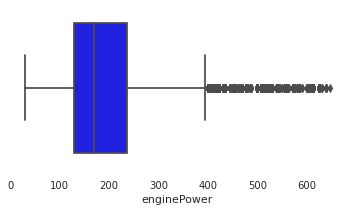

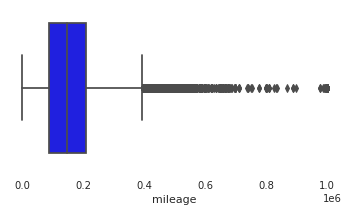

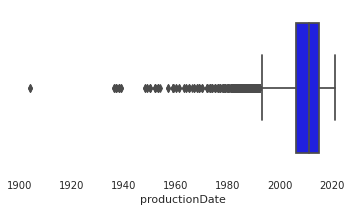

In [120]:
# Посмотрим на выбросы в числовых признаках:

def outliers_iqr(col): #Избавление числового признака от выбросов
        quartile_1, quartile_3 = np.percentile(list(col), [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return comb_df[col < upper_bound][col > lower_bound]
    
def plot_boxplots(features): # Построение boxpots
    for feature in features:
        plt.figure(figsize=(6,3))
        sns.boxplot(features[feature], color = 'blue')
        print('Среднее значение {} = {:.3f}'.format(feature, features[feature].mean()))
    
    
plot_boxplots(comb_df[num_cols])
    



Вполне нормальные данные по авто, выбросы относятся к раритетным и машинам с мощным двигателем

### 3.4.5. Feature Engineering

In [121]:
print(num_cols)

['enginePower', 'mileage', 'productionDate']


Признак productionDate вызывает вопрос. Лучше использовать возраст автомобиля вместо года производства. Также создадим новый признак: средний годовой пробег.

In [122]:
comb_df['age'] = 2021 - comb_df.productionDate
comb_df['mileage_per_year'] = round(comb_df['mileage'] / comb_df['age'], 0)
num_cols = num_cols+['age','mileage_per_year']
num_cols.remove('productionDate')
comb_df.drop(['productionDate'], axis=1, inplace=True)

Также создадим следующие новые признаки:

1) столбец обозначающий старые автомобили (старше 10 лет) так как цена на них не сильно зависит от возраста

2) столбец обозначающий редкие цвета так как это чвсто дорогие автомобили

3) автомобили с редкими типами кузова которые могут обозначать высокую цену

Признаки эти бинарны

In [123]:
comb_df['old_car'] = comb_df.age.apply(lambda x: 1 if x >10 else 0)
comb_df['rare_colors'] = comb_df.color.apply(lambda x: 1 if x in ['фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый'] else 0)
comb_df['rare_bodyType'] = comb_df.bodyType.apply(lambda x: 1 if x in ['микровэн', 'седан-хардтоп', 'лимузин', 'тарга', 'фастбек'] else 0)
bin_cols = bin_cols+['old_car','rare_colors','rare_bodyType']

In [124]:
# Прологорифмируем числовые признаки
comb_df['enginePower_log2'] = np.log2(comb_df.enginePower+1)
comb_df['enginePower_log2'].replace([np.inf, -np.inf], 0, inplace=True)
comb_df['mileage_log2'] = np.log2(comb_df.mileage+1)
comb_df['mileage_log2'].replace([np.inf, -np.inf], 0, inplace=True)
comb_df['age_log2'] = np.log2(comb_df.age+1)
comb_df['age_log2'].replace([np.inf, -np.inf], 0, inplace=True)
comb_df['mileage_per_year_log2'] = np.log2(comb_df.mileage_per_year+1)
comb_df['mileage_per_year_log2'].replace([np.inf, -np.inf], 0, inplace=True)
# Удалим старые слолбцы
comb_df.drop(['enginePower','mileage','age','mileage_per_year'], axis=1, inplace=True)
num_cols = ['enginePower_log2', 'mileage_log2', 'age_log2', 'mileage_per_year_log2']

Проанализируем

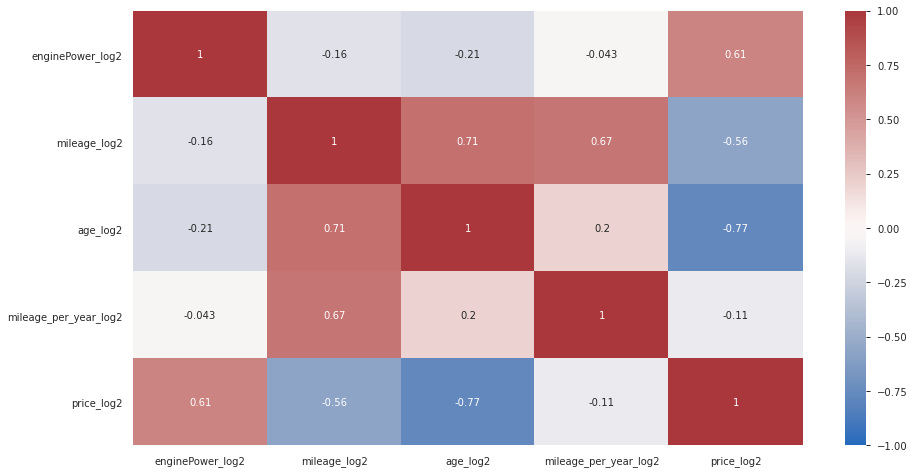

In [125]:
# Посмотрим на корреляцию новых числовых параметров с ценой (нашим таргетом)
plt.figure(figsize=(15, 8));
sns.heatmap(comb_df[comb_df.train == 1][num_cols + ['price_log2']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

Могло быть и получше, ну что же

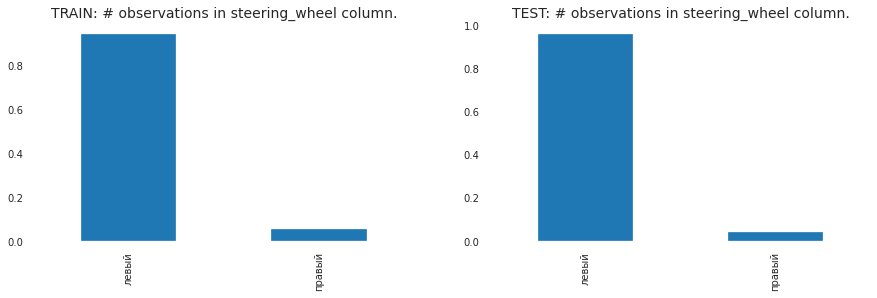

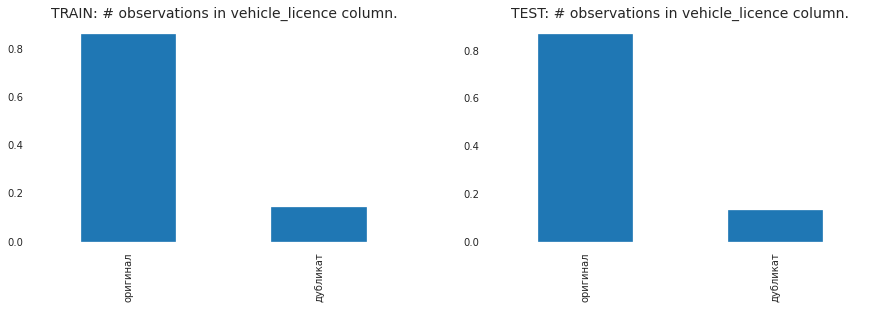

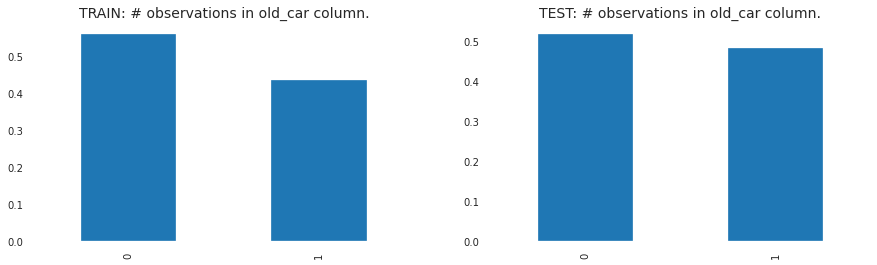

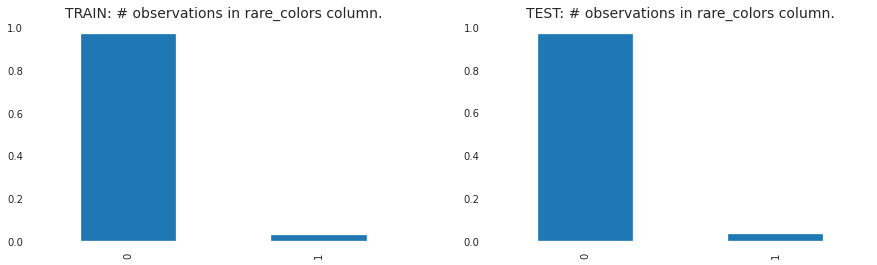

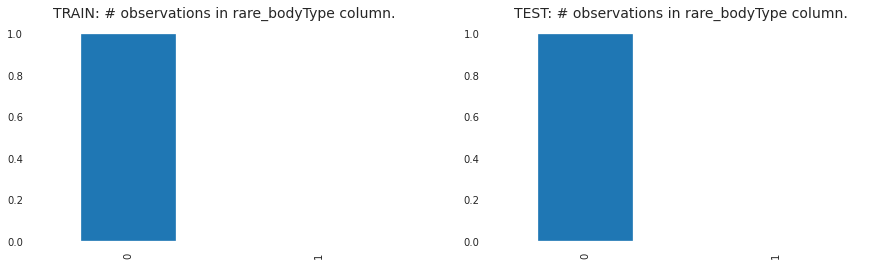

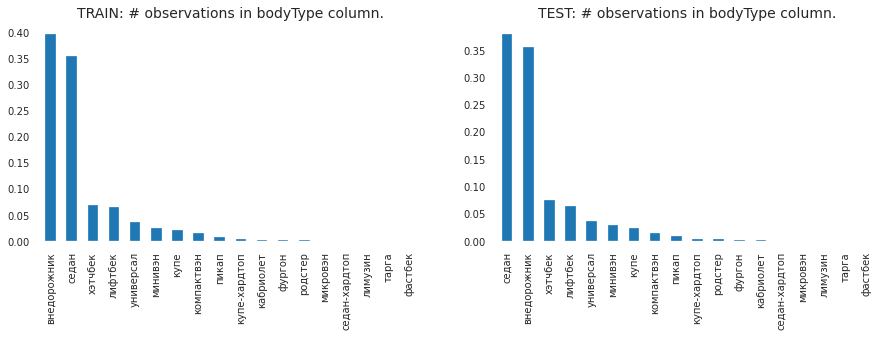

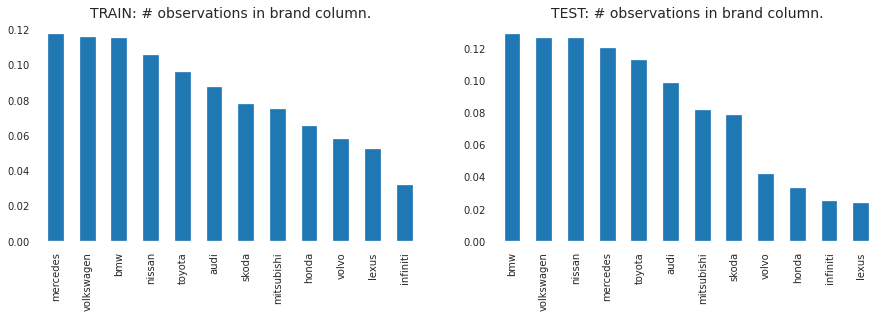

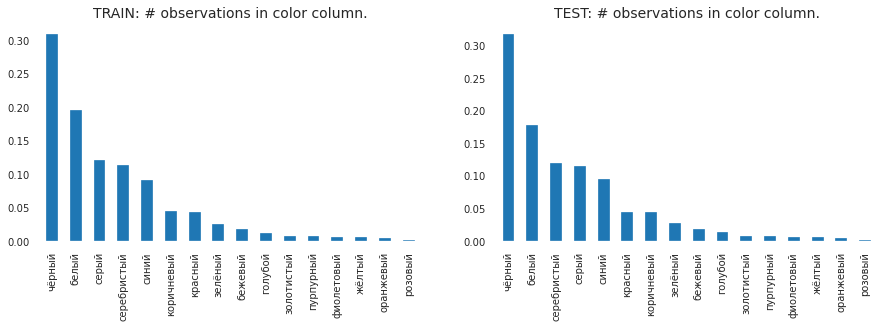

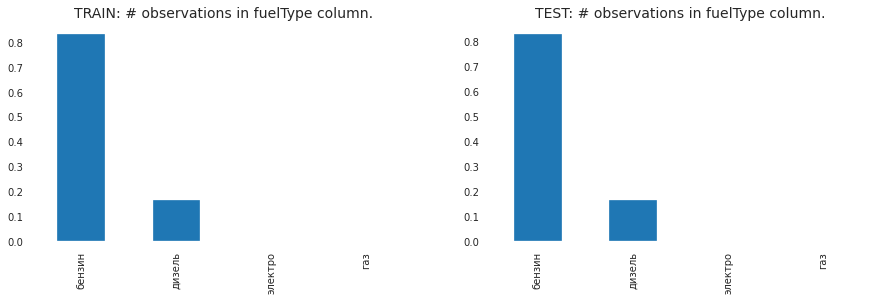

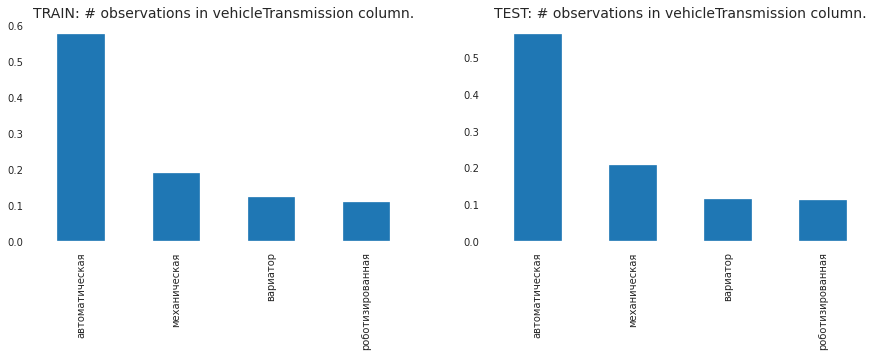

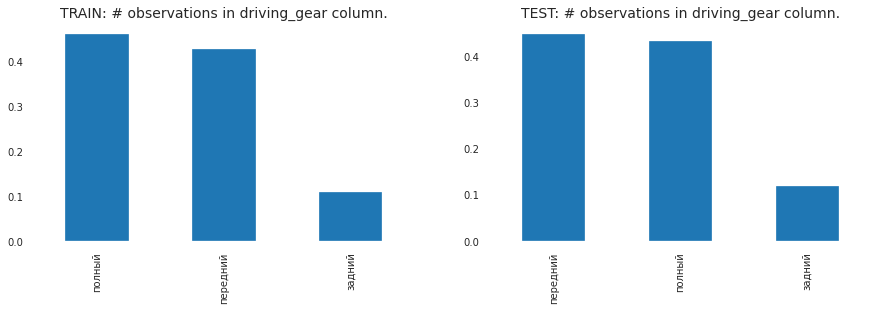

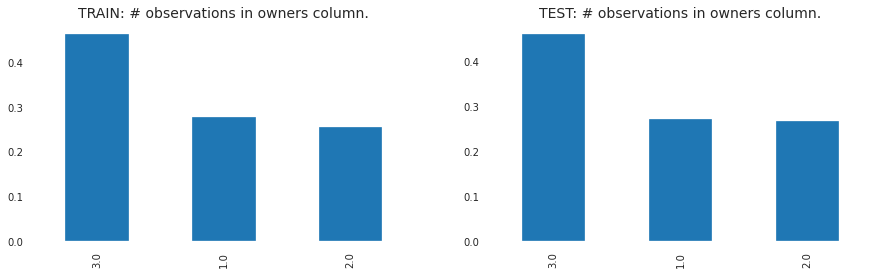

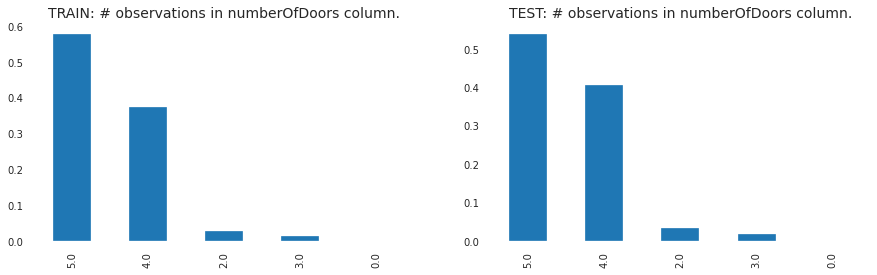

In [126]:
# Посмотрим на сбалансирование бинарных и категоральных признаков трейнового и тестового датасетов
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        comb_df[comb_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

In [127]:
# Сделаем Label Encoding для бинарных и категоральных признаков
for colum in ['steering_wheel', 'vehicleTransmission', 'vehicle_licence', 'driving_gear',
              'fuelType', 'color', 'brand', 'bodyType']:
    comb_df[colum] = comb_df[colum].astype('category').cat.codes

cols_to_encode = list(set(comb_df.columns) & set(cat_cols))
for colum in cols_to_encode:
    comb_df[colum] = comb_df[colum].astype('category').cat.codes

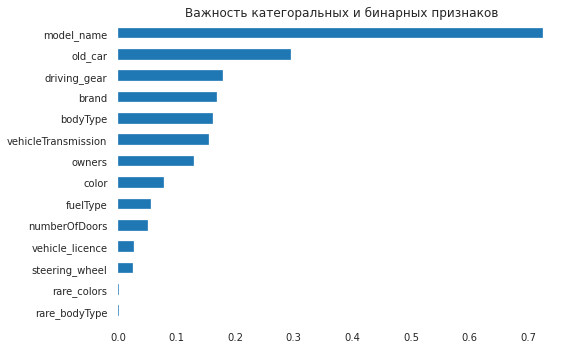

In [128]:
# Теперь посмотрим на важность бинарных и категоральных признаков
imp_cat = pd.Series(
    mutual_info_regression(
        comb_df[comb_df.train == 1][list(set(comb_df.columns) & set(cat_cols+bin_cols))], 
        comb_df[comb_df.train == 1]['price_log2'], 
        discrete_features=True), index=list(set(comb_df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Важность категоральных и бинарных признаков')
plt.show()

Неплохо . Можно подавать в модели

# 4. Machine Learning

## 4.1. Разделение данных

Разделим трейновые данные на непосредственно трейновые и тестовые. Также обозначим данные для сабмишена

In [129]:
X = comb_df.query('train == 1').drop(['sell_id', 'price', 'price_log2', 'train'], axis=1)
X_sub = comb_df.query('train == 0').drop(['sell_id', 'price','price_log2', 'train'], axis=1)
y = comb_df.query('train == 1').price

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## 4.2. Построение и тестирование моделей

### 4.2.1. Наивная модель

Создадим наивную модель которая будет предсказывать стоимость автомобиля по его возрасту

In [131]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [132]:
# Находим median по экземплярам age_log2 в трейне и размечаем значения на тесте
predict = X_test['age_log2'].map(tmp_train.groupby('age_log2')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 49.98%


Точность наивной модели по метрике MAPE: 49.65%

### 4.2.2. Catboost

Параметры для этой модели были взяты из Baseline.

In [133]:
catboost = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
catboost.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

# оцениваем точность
predict_catboost = catboost.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_catboost))*100:0.2f}%")

Точность модели по метрике MAPE: 18.44%


Точность модели по метрике MAPE: 17.66%

Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    

In [134]:
catboost_log = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
catboost_log.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

predict_catboost_log = np.exp(catboost_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_catboost_log))*100:0.2f}%")

Точность модели по метрике MAPE: 15.66%


Точность модели по метрике MAPE: 15.52%

Точность после передачи логарифмированного target заметно улучшилась. Будем это использовать в других моделях.


### 4.2.3. LGBMRegressor с подбором гиперпараметров

In [135]:
# Запустим модель со стандартными параметрами
lgbm_log = LGBMRegressor(random_state=RANDOM_SEED)
lgbm_log.fit(X_train, np.log(y_train))
predict_lgbm_log = np.exp(lgbm_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbm_log))*100:0.2f}%")

Точность модели по метрике MAPE: 17.57%


Точность модели по метрике MAPE: 17.35%

In [136]:
## Создадим сетку для подбора гиперпараметров и пройдемся по ней

#lgbm_log_param_dic = {
# 'learning_rate':[0.005, 0.01, 0.015],
# 'num_leaves':[250, 500, 1000],
# 'colsample_bytree': [0.5, 1],
# 'min_child_samples': [5, 10, 20]
#}

#lgbm_log_grid = GridSearchCV(lgbm_log, lgbm_log_param_dic, n_jobs=-1,
#                             refit=True, cv=2, return_train_score=True, verbose=5)


#lgbm_log_grid.fit(X_train, np.log(y_train))
#print(lgbm_log_grid.best_params_)

Перебор гиперпараметров занял не один час. В итоге получился следующий результат:

Fitting 2 folds for each of 54 candidates, totalling 108 fits
{'colsample_bytree': 1, 'learning_rate': 0.015, 'min_child_samples': 5, 'num_leaves': 1000}

In [137]:
# Запустим модель с подобранными гиперпараметрами
lgbm_log = LGBMRegressor(random_state=RANDOM_SEED, objective = 'regression', num_iterations = 1000, 
                           n_estimators = 1000, learning_rate = 0.015, num_leaves = 1000, max_depth = -1,  
                           min_child_samples = 5,  colsample_bytree = 1)
lgbm_log.fit(X_train, np.log(y_train))
predict_lgbm_log = np.exp(lgbm_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_lgbm_log))*100:0.2f}%")

Точность модели по метрике MAPE: 16.11%


Точность модели по метрике MAPE: 15.93%
Выжать точность побольше не получается скорее всего из за малого количества данных

### 4.2.4. XGBoostRegressor

In [138]:
# Запустим модель с параметрами подобранными вручную по смыслу (перебор по сетке занимает много времени)
xgb_log = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree= 0.5,               
    learning_rate=0.1, 
    max_depth= 12, 
    alpha=1,                   
    n_estimators=1000,
    random_state=RANDOM_SEED,
    verbose=1, 
    n_jobs=-1)

xgb_log.fit(X_train, np.log(y_train))
predict_xgb_log = np.exp(xgb_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_xgb_log))*100:0.2f}%")

[01:16:41] WARNING: ../src/learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Точность модели по метрике MAPE: 15.81%


Точность модели по метрике MAPE: 15.72%

Тоже не плохо

### 4.2.5. Random forest 

In [139]:
# Запустим модель со стандартными параметрами
rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
rf_log.fit(X_train, np.log(y_train))
predict_rf_log = np.exp(rf_log.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rf_log) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Точность модели по метрике MAPE: 16.47%.


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


Точность модели по метрике MAPE: 16.35%

MAE колеблется от 15.72 и выше, подбор гиперпараметров улучшил точность ,но до ТОР далековато (: 

### 4.2.6. Extra Tree Regressor с подбором гиперпараметров

In [140]:
# Запустим модель со стандартными параметрами
etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr_log.fit(X_train, np.log(y_train))
predict_etr_log = np.exp(etr_log.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_etr_log))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Точность модели по метрике MAPE: 17.28%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


Точность модели по метрике MAPE: 16.97%
Что то получилось, не лучший результат 

In [141]:
## Подберем гиперпараметры с помощью hyperopt
#hp.uniform('n_estimators',100,500),
#hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])
#
#def objective(params):
#    model=ExtraTreesRegressor(
#        n_estimators=int(params['n_estimators']),
#        max_depth=int(params['max_depth']),
#        min_samples_leaf=int(params['min_samples_leaf']),
#        min_samples_split=int(params['min_samples_split']),
#        bootstrap=params['bootstrap'],
#        max_features=params['max_features'],
#        random_state=RANDOM_SEED,
#        n_jobs=-1
#    )
#    model.fit(X_train, np.log(y_train))
#    pred=model.predict(X_test)
#    score=mape(y_test,np.exp(pred))
#    return score

#def optimize(trial):
#    params={
#        'n_estimators': hp.uniform('n_estimators',100,500),
#        'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#        'max_depth': hp.uniform('max_depth',5,15),
#        'min_samples_split': hp.uniform('min_samples_split',2,10),
#        'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#        'bootstrap': hp.choice("bootstrap", [True, False])
#    }
#    best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.RandomState(RANDOM_SEED))
#    return best

#trial=Trials()
#best=optimize(trial)

In [142]:
#best #(результаты)

Подбор занял 15 минут и в итоге дал следующий результат:

best = {'bootstrap': 1,
 'max_depth': 14.149743820071635,
 'max_features': 0,
 'min_samples_leaf': 1.9153096840827872,
 'min_samples_split': 4.041822394468241,
 'n_estimators': 194.71822939909046}

In [143]:
# Запустим модель с подобранными гирерпараметрами
etr_log_hp = ExtraTreesRegressor(random_state=RANDOM_SEED, 
                                   n_jobs=-1, 
                                   verbose=1, 
                                   n_estimators = 195, 
                                   min_samples_split = 4, 
                                   min_samples_leaf = 2, 
                                   max_features = 'auto', 
                                   max_depth = 14, 
                                   bootstrap = 1)

etr_log_hp.fit(X_train, np.log(y_train))
predict_etr_log_hp = np.exp(etr_log_hp.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_etr_log_hp))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Точность модели по метрике MAPE: 17.00%


[Parallel(n_jobs=4)]: Done 195 out of 195 | elapsed:    0.2s finished


Точность модели по метрике MAPE: 16.85%

Чуть чуть получше

Подбор гиперпараметров не улучшил результат ,скорее всего мало данных и результат не так заметен

### 4.2.7. Stacking

Объединим три модели в одну

In [144]:
estimators = [
    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('lgmb', LGBMRegressor(random_state=RANDOM_SEED, objective = 'regression', num_iterations = 1000, n_estimators = 1000, learning_rate = 0.015, num_leaves = 1000, max_depth = -1,  
                           min_child_samples = 5,  colsample_bytree = 1))]

stacking_log = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

stacking_log.fit(X_train, np.log(y_train))

predict_stacking_log = np.exp(stacking_log.predict(X_test))

print(f"The MAPE mertic for the default StackingRegressor model: {(mape(y_test, predict_stacking_log) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: D

The MAPE mertic for the default StackingRegressor model: 15.99%.


Точность модели по метрике MAPE: 15.79%

Stacking выдал средние результаты МАРЕ: результат 15.79% значительно лучше каждой модели по отдельности (etr = 16.97%, rf = 16.35%, lgmb = 15.93%). 

Stacking помог улучшить результат.

Скорее всего на больших количествах данных результат может быть и лучше



# 5. Submission

In [145]:
VERSION=1
predict_submission = np.exp(etr_log.predict(X_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


,sell_id,price
0,1100575026,5.490000e+05
1,1100549428,8.950000e+05
2,1100658222,8.936897e+05
3,1100937408,7.075085e+05
4,1101037972,8.742662e+05
5,1100912634,7.994259e+05
6,1101228730,6.081899e+05
7,1100165896,3.650000e+05
8,1100768262,2.012914e+06
9,1101218501,7.320811e+05


# 6. Заключение

Вроде получился неплохой результат.Могло быть и лучше если бы было больше данных, жаль не получилось спарсить данные с auto.ru

Точность можно было бы повысить если поработать со столбцом где дана комплектация автомобиля (что то выделить из этой кучи)

Было интересно проверить теорию и увидеть результаты работы на практике
